In [1]:
from datetime import datetime
import datetime as dt
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import pandas as pd
import pytz
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import ar_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pandas.plotting import lag_plot
import prophet as mtp

Importing plotly failed. Interactive plots will not work.


In [2]:
# Display MetaTrader5 package information

print(f"MetaTrader5 package version: {mt5.__version__}")
print(f"MetaTrader5 author: {mt5.__author__}")


lst_ = ['EURUSD', 'XAUEUR', 'XAUUSD', 'XAUAUD']
dict_ = {}

for i in lst_:
    # Initialize connection to the MetaTrader 5 terminal
    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        quit()

    # Set the time zone to UTC
    timezone = pytz.timezone("Africa/Nairobi")

    # Define the date and time range for historical data

    utc_from = datetime(2023, 1, 1, tzinfo=timezone)
    utc_to = datetime.now(tz=timezone)

 # Get historical price data for USD/JPY on a 30-minute timeframe
    symbol = i
    timeframe = mt5.TIMEFRAME_M30
    rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_to)

    # Shut down the connection to the MetaTrader 5 terminal
    mt5.shutdown()

    # Display the first 10 elements of the obtained data
    # print("Display obtained data 'as is'")
#     for rate in rates[:10]:
#          print(rate)


    # Create a DataFrame from the obtained data
    dict_[f'df_30_{i}'] = pd.DataFrame(rates)
    dict_[f'df_30_{i}'].drop(columns=['open', 'high', 'low', 'tick_volume', 'spread',
       'real_volume'], inplace=True)

    # Convert time in seconds to 'datetime' format
    dict_[f'df_30_{i}']['time'] = pd.to_datetime(dict_[f'df_30_{i}']['time'], unit='s')
print('Completed Loading :)')

MetaTrader5 package version: 5.0.45
MetaTrader5 author: MetaQuotes Ltd.
Completed Loading :)


In [3]:
dict_2 = {}
start_time = pd.to_datetime('00:00:00').time()
end_time = pd.to_datetime('04:00:00').time()
for i in dict_.keys():
    dict_2[f'{i}_ft'] = dict_[i][(dict_[i]['time'].dt.time>=start_time)&(dict_[i]['time'].dt.time<=end_time)]

In [4]:
dict_2.keys()

dict_keys(['df_30_EURUSD_ft', 'df_30_XAUEUR_ft', 'df_30_XAUUSD_ft', 'df_30_XAUAUD_ft'])

In [5]:
result = adfuller(dict_2['df_30_XAUUSD_ft']['close'])
p_value = result[1]
if p_value>0.05:
    print('The series is not stationary')
else:
    print('The series is stationary')

The series is not stationary


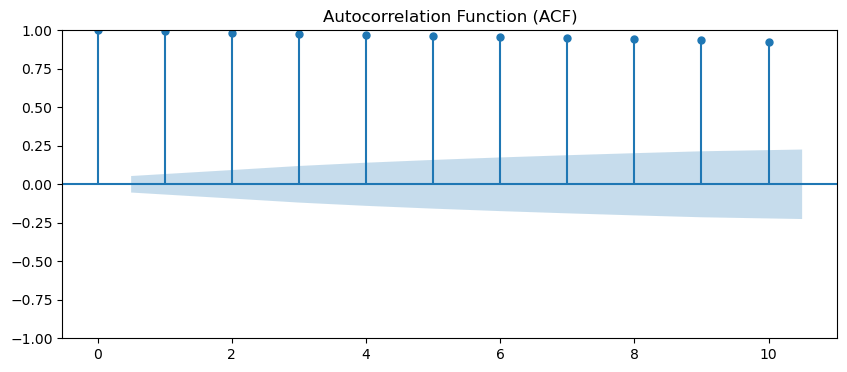

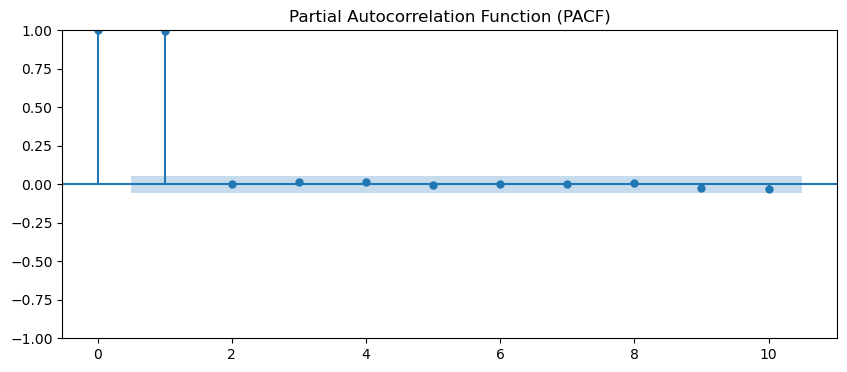

In [6]:
fig, ax =plt.subplots(figsize=(10, 4))
# Calculate and plot the ACF
plot_acf(dict_2['df_30_XAUUSD_ft']['close'], lags=10, ax=ax)  # Adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Calculate and plot the PACF
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(dict_2['df_30_XAUUSD_ft']['close'], lags=10, ax=ax)  # Adjust the number of lags as needed
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

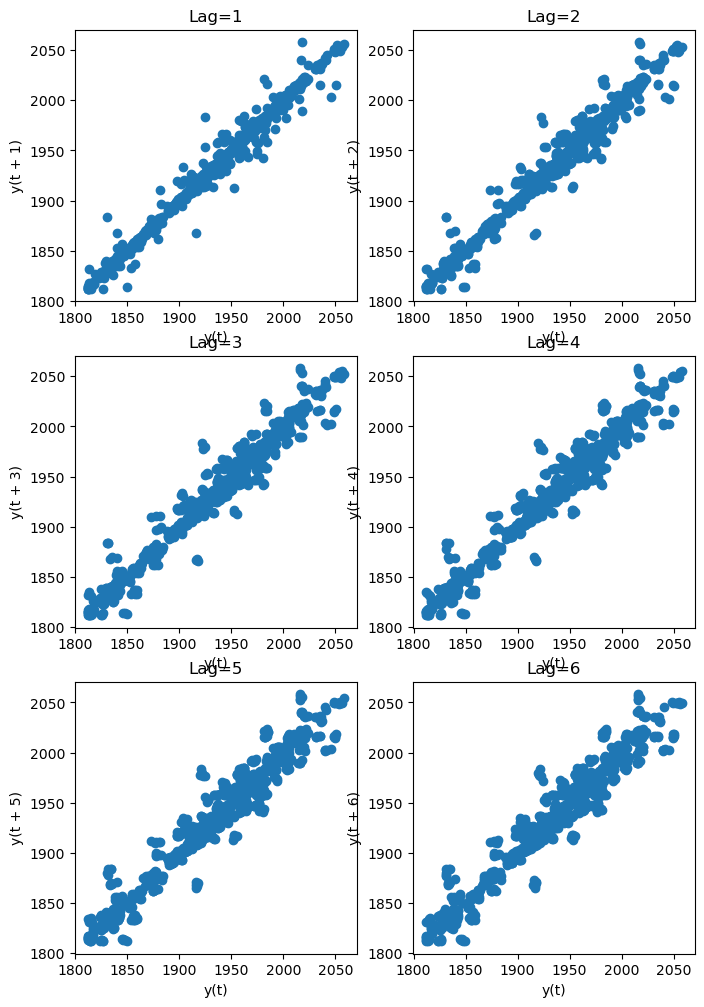

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
plt.title('MSFT Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(dict_2['df_30_XAUUSD_ft']['close'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.show()

In [8]:
dict_2['df_30_XAUUSD_ft'].columns = ["ds", "y"]

In [9]:
dict_2['df_30_XAUUSD_ft'].tail()

,ds,y
8570,2023-09-22 01:30:00,1920.10
8571,2023-09-22 02:00:00,1920.68
8572,2023-09-22 02:30:00,1921.38
8573,2023-09-22 03:00:00,1921.68
8574,2023-09-22 03:30:00,1923.46


In [10]:
model = mtp.Prophet()
model.add_seasonality(name='semi_hourly', period=48, fourier_order=5)

In [11]:
#get custom half-hourly predictions

model.fit(dict_2['df_30_XAUUSD_ft'])
future = model.make_future_dataframe(periods=4, freq='30T')
forecast = model.predict(future)

06:47:14 - cmdstanpy - INFO - Chain [1] start processing
06:47:22 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
forecast[['ds', 'yhat']].tail()

,ds,yhat
1334,2023-09-22 03:30:00,1916.703119
1335,2023-09-22 04:00:00,1917.155385
1336,2023-09-22 04:30:00,1917.859251
1337,2023-09-22 05:00:00,1918.394343
1338,2023-09-22 05:30:00,1917.931259


In [20]:
dict_2['df_30_XAUUSD_ft'].tail()

,ds,y
8570,2023-09-22 01:30:00,1920.10
8571,2023-09-22 02:00:00,1920.68
8572,2023-09-22 02:30:00,1921.38
8573,2023-09-22 03:00:00,1921.68
8574,2023-09-22 03:30:00,1923.46


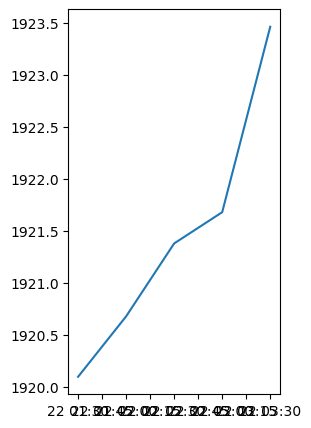

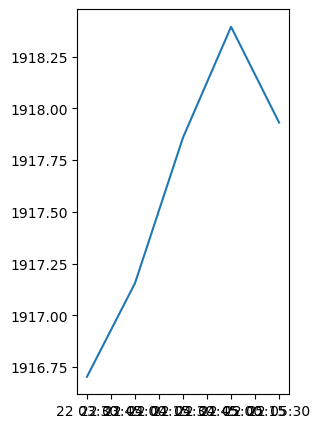

In [36]:
df_act = dict_2['df_30_XAUUSD_ft'].tail()
plt.figure(figsize=(6, 5))
plt.subplot(1, 2, 1)
plt.plot(df_act['ds'], df_act['y'], label="Actual Gold Price Movements")

forecast_ = forecast.tail()
plt.figure(figsize=(6, 5))
plt.subplot(1, 2, 2)
plt.plot(forecast_['ds'], forecast_['yhat'], label="Predicted Gold movements")

<AxesSubplot: xlabel='ds'>

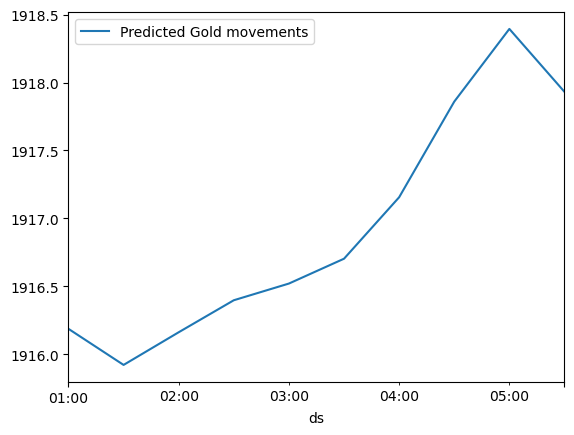

In [18]:
forecast.tail(10).plot('ds', 'yhat', label="Predicted Gold movements")

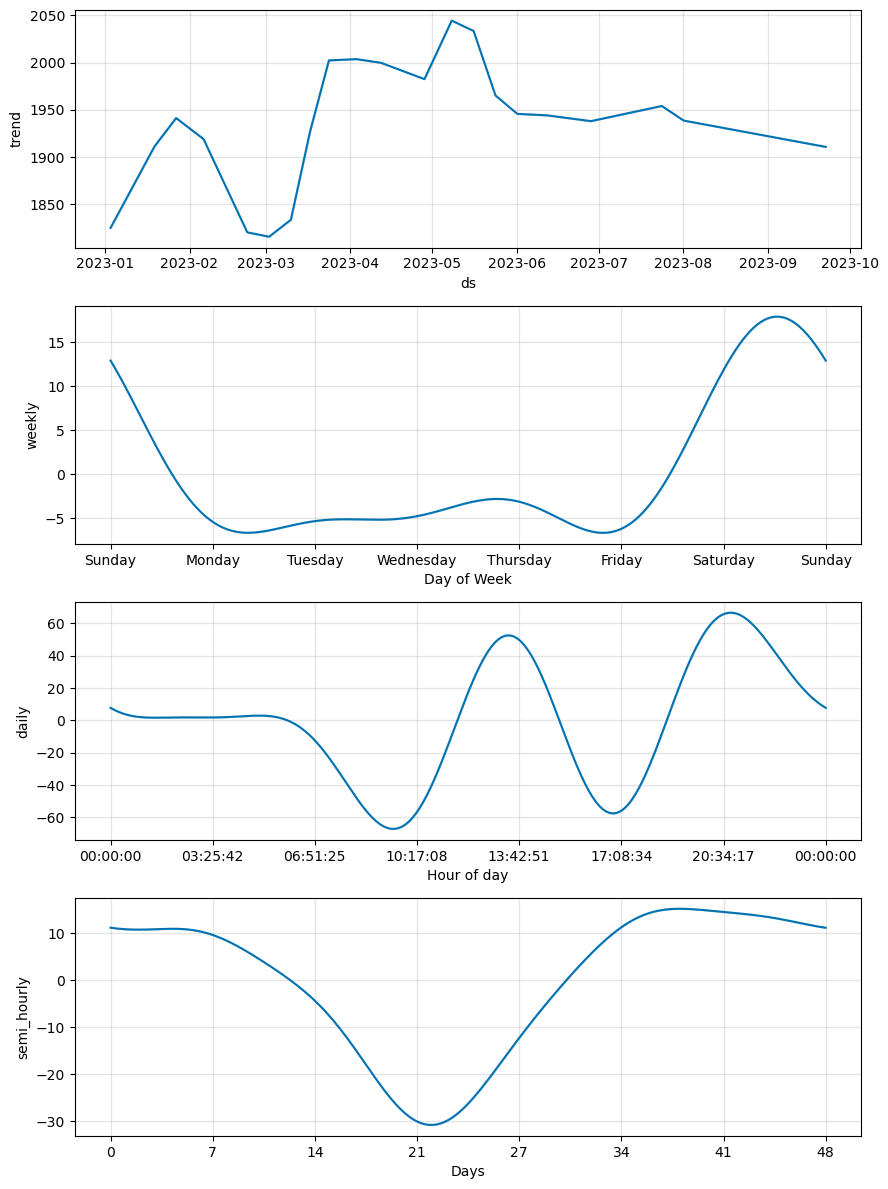

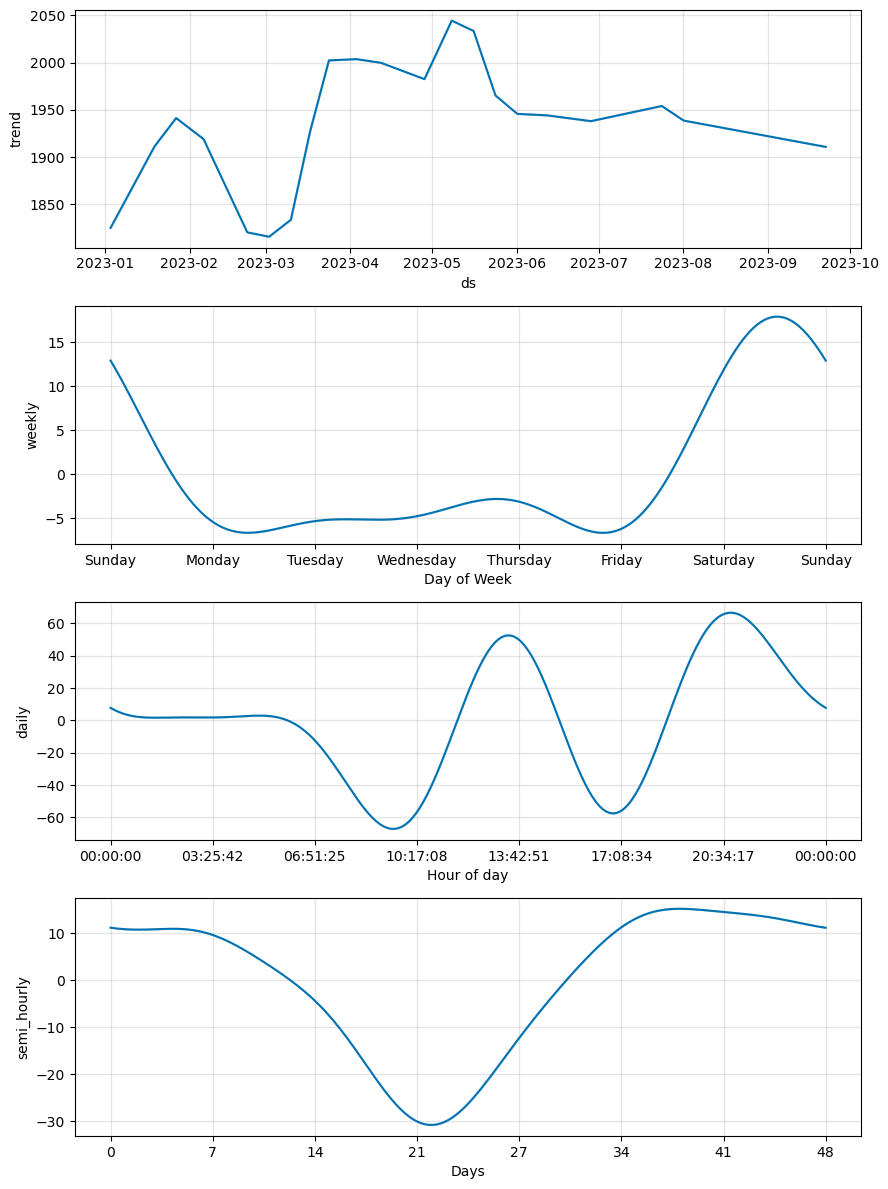

In [15]:
model.plot_components(forecast)